In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib


In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor


In [3]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
onlyfiles = [f for f in listdir("files") if isfile(join("files", f))]

energyPrices=pd.read_csv("files/"+onlyfiles[0], encoding='ISO-8859-1')
commercialRealEstate = pd.read_csv("files/"+onlyfiles[1] , encoding='ISO-8859-1')
constructionMaterials=pd.read_csv("files/"+onlyfiles[2], encoding='ISO-8859-1')
realGDP=pd.read_csv("files/"+onlyfiles[3], encoding='ISO-8859-1')
IndustrialRevenue=pd.read_csv("files/"+onlyfiles[4], encoding='ISO-8859-1')
OfficeRealEstate=pd.read_csv("files/"+onlyfiles[5], encoding='ISO-8859-1')
labourCosts=pd.read_csv("files/"+onlyfiles[6], encoding='ISO-8859-1')
corporateDebt=pd.read_csv("files/"+onlyfiles[7], encoding='ISO-8859-1')

bankruptcies=pd.read_csv("files/"+onlyfiles[8], encoding='ISO-8859-1')

inflaatio=pd.read_csv("files/"+onlyfiles[9], encoding='utf-8-sig', sep=';')

consumerconf= pd.read_csv("files/"+onlyfiles[10], encoding='utf-8-sig', sep=';')


In [4]:
corDebtDiff = corporateDebt[3108:3367] # data  01/2003 - 07/2024,with 259 datapoints
corDebtDiff = corDebtDiff["txtb_value"].str.replace(',', '.').astype(float)
corDebtDiff = corDebtDiff.to_numpy().reshape(-1, 1)
bankruptcies.rename(columns={"Unnamed: 1": "Amount"}, inplace=True)
y = bankruptcies[204:463]
y = y["Amount"]
y = y.to_numpy().reshape(-1,1)










In [5]:
inf = pd.to_numeric(inflaatio['Unnamed: 1'].str.replace(',', '.', regex=False).str.replace('−', '-', regex=False), errors='coerce')  # 
inf = inf.iloc[276:535]
inf = inf.to_numpy().reshape(-1, 1)

conf = pd.to_numeric(consumerconf["Unnamed: 1"].str.replace(',', '.', regex=False).str.replace('−', '-', regex=False), errors='coerce')
conf = conf.iloc[87:346]
conf = conf.to_numpy().reshape(-1, 1)











In [6]:
data_matrix = np.hstack((inf, corDebtDiff, conf)) 

kf = KFold(n_splits=3, shuffle=True, random_state=42)
train_sets = []
val_sets = []
# Perform K-Fold split
for fold, (train_index, val_index) in enumerate(kf.split(data_matrix), start=1):
    # Splitting the features
    corDebtDiff_train, corDebtDiff_val = corDebtDiff[train_index], corDebtDiff[val_index]
    inf_train, inf_val = inf[train_index], inf[val_index]
    conf_train, conf_val = conf[train_index], conf[val_index]

    # Splitting the target variable
    y_train, y_val = y[train_index], y[val_index]

    # Store the sets in dictionaries or tuples
    train_sets.append({
        'corDebtDiff_train': corDebtDiff_train,
        'inf_train': inf_train,
        'conf_train': conf_train,
        'y_train': y_train
    })
    
    val_sets.append({
        'corDebtDiff_val': corDebtDiff_val,
        'inf_val': inf_val,
        'conf_val': conf_val,
        'y_val': y_val
    })


In [7]:
def calculate_errors(train_sets, val_sets, max_degree=4):
    results = []

    # Iterate over polynomial degrees (from 1 to max_degree)
    for degree in range(1, max_degree + 1):
        train_errors = []
        val_errors = []

        # For each fold
        for i in range(len(train_sets)):
            # Get training and validation sets for the current fold
            X_train = np.hstack((train_sets[i]['corDebtDiff_train'], 
                                 train_sets[i]['inf_train'], 
                                 train_sets[i]['conf_train']))
            y_train = train_sets[i]['y_train']

            X_val = np.hstack((val_sets[i]['corDebtDiff_val'], 
                               val_sets[i]['inf_val'], 
                               val_sets[i]['conf_val']))
            y_val = val_sets[i]['y_val']

            poly = PolynomialFeatures(degree)
            X_train_poly = poly.fit_transform(X_train)
            X_val_poly = poly.transform(X_val)

            # Train the linear regression model
            model = LinearRegression()
            model.fit(X_train_poly, y_train)

            # Predict and calculate errors
            y_train_pred = model.predict(X_train_poly)
            y_val_pred = model.predict(X_val_poly)

            train_error = mean_squared_error(y_train, y_train_pred) 
            val_error = mean_squared_error(y_val, y_val_pred)       

            train_errors.append(train_error)
            val_errors.append(val_error)

        # Average errors across folds
        avg_train_error = np.mean(train_errors)
        avg_val_error = np.mean(val_errors)

        # Append the results to the list
        results.append({
            'poly degree': degree,
            'train_errors': avg_train_error,
            'val_errors': avg_val_error
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Call the function with the train_sets and val_sets
results_df = calculate_errors(train_sets, val_sets, max_degree=4)

# Display the results
print(results_df)

   poly degree  train_errors   val_errors
0            1   1974.915416  2074.727862
1            2   1885.837259  2092.798951
2            3   1744.481328  2198.903996
3            4   2646.051405  5683.615169


In [8]:

scaler = StandardScaler()
data_matrix_scaled = scaler.fit_transform(data_matrix) # scale the data with Z-score normalisation
pca = PCA(n_components=1) 
data_matrix_pca = pca.fit_transform(data_matrix_scaled)

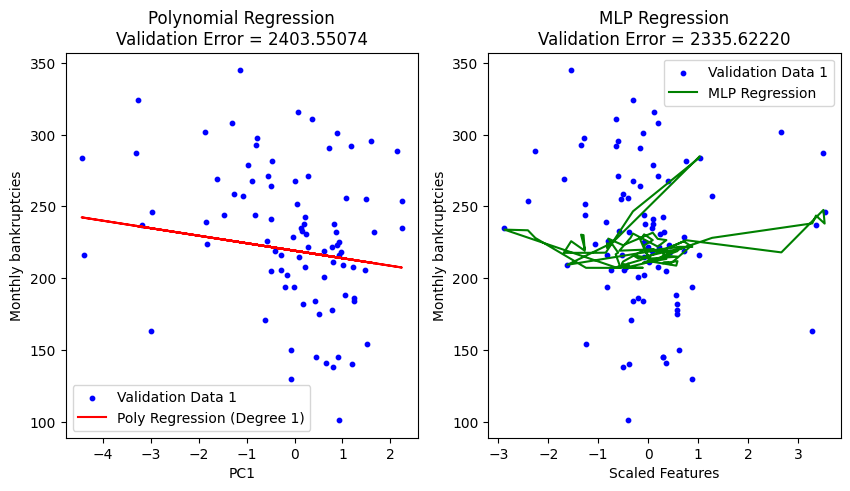

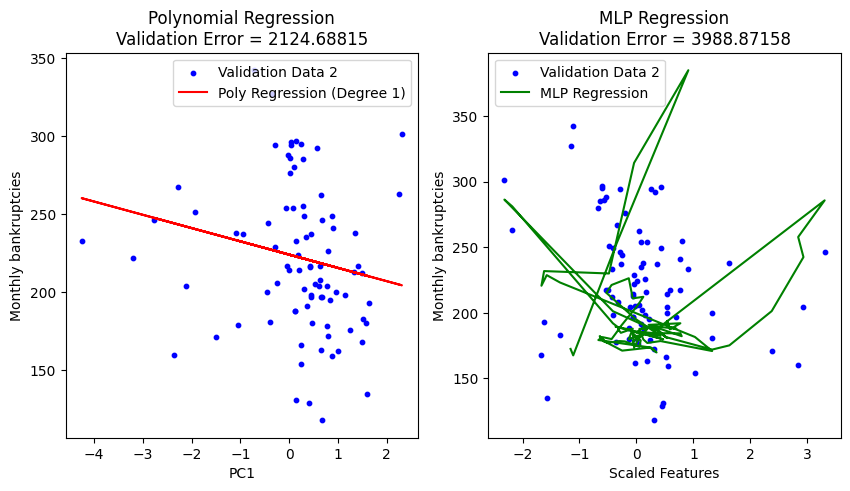

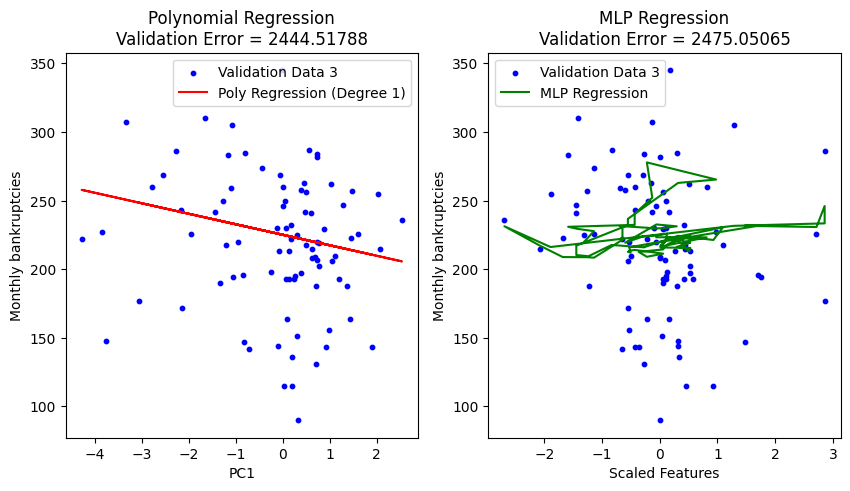

                   Model  Train Error  Validation Error
0  Polynomial Regression  2272.576201       2324.252257
1         MLP Regression  2909.394928       2933.181476


In [36]:
def k_fold_cross_validation_with_models(train_sets, val_sets, degree=1):
    # Store errors for both models
    poly_train_errors = []
    poly_val_errors = []
    mlp_train_errors = []
    mlp_val_errors = []
    
    for fold in range(len(train_sets)):
        # Prepare training and validation data for the current fold
        X_train = np.hstack((train_sets[fold]['corDebtDiff_train'], 
                             train_sets[fold]['inf_train'], 
                             train_sets[fold]['conf_train']))
        y_train = train_sets[fold]['y_train']
        
        X_val = np.hstack((val_sets[fold]['corDebtDiff_val'], 
                           val_sets[fold]['inf_val'], 
                           val_sets[fold]['conf_val']))
        y_val = val_sets[fold]['y_val']

        # Standardize both training and validation sets using Z-score normali 
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # PCA on both training and validation sets
        pca = PCA(n_components=1)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        ### Polynomial Regression ###
        # Polynomial Features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_pca)
        X_val_poly = poly.transform(X_val_pca)

        # Linear Regression model
        lin_regr = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)
        
        # Predictions and errors for polynomial regression
        y_train_pred_poly = lin_regr.predict(X_train_poly)
        y_val_pred_poly = lin_regr.predict(X_val_poly)

        poly_train_errors.append(mean_squared_error(y_train, y_train_pred_poly))  
        poly_val_errors.append(mean_squared_error(y_val, y_val_pred_poly))      

        ### MLP Regression ###
        # Train MLP Regressor
        mlp = MLPRegressor(hidden_layer_sizes=(100,5), max_iter=2000, 
                   learning_rate_init=0.001, activation='relu', 
                   early_stopping=True, random_state=1 )
        mlp.fit(X_train_pca, y_train.ravel())  
        
        # Predictions and errors for MLP
        y_train_pred_mlp = mlp.predict(X_train_pca)
        y_val_pred_mlp = mlp.predict(X_val_pca)

        mlp_train_errors.append(mean_squared_error(y_train, y_train_pred_mlp))  
        mlp_val_errors.append(mean_squared_error(y_val, y_val_pred_mlp))        

        # Plotting for MLP
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)  # Subplot for Polynomial Regression
        plt.scatter(X_val_pca[:, 0], y_val, color="b", s=10, label="Validation Data {}".format(fold+1))
        plt.plot(X_val_pca[:, 0], y_val_pred_poly, color='r', label="Poly Regression (Degree {})".format(degree))
        plt.xlabel('PC1')
        plt.ylabel('Monthly bankruptcies')
        plt.legend(loc="best")
        plt.title(f'Polynomial Regression\nValidation Error = {poly_val_errors[-1]:.5f}')

        plt.subplot(1, 2, 2)  # Subplot for MLP
        plt.scatter(X_val_scaled[:, 0], y_val, color="b", s=10, label="Validation Data {}".format(fold+1))
        plt.plot(X_val_scaled[:, 0], y_val_pred_mlp, color='g', label="MLP Regression")
        plt.xlabel('Scaled Features')
        plt.ylabel('Monthly bankruptcies')
        plt.legend(loc="best")
        plt.title(f'MLP Regression\nValidation Error = {mlp_val_errors[-1]:.5f}')
        plt.show()


    # Average errors across folds
    avg_poly_train_error = np.mean(poly_train_errors)
    avg_poly_val_error = np.mean(poly_val_errors)
    
    avg_mlp_train_error = np.mean(mlp_train_errors)
    avg_mlp_val_error = np.mean(mlp_val_errors)

    # Store results in DataFrame
    results_df = pd.DataFrame({
        'Model': ['Polynomial Regression', 'MLP Regression'],
        'Train Error': [avg_poly_train_error, avg_mlp_train_error],
        'Validation Error': [avg_poly_val_error, avg_mlp_val_error]
    })

    return results_df

# Example: Call the function with train and validation sets
results_df = k_fold_cross_validation_with_models(train_sets, val_sets, degree=1)

# Display results
print(results_df)